# Download data

To run this notebook you will need to download the GW data.

`python download_GW170817_data.py`

# Demo

Use the L1 GW170817 data to demonstrate (i) glitch removal, (ii) bandpass filtering, and (iii) whitening in the wavelet time-frequency domain.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import WDM

# Load data

In [2]:
path = "../data/L-L1_GWOSC_4KHZ_R1-1187006835-4096.txt"

with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.startswith('#'):
            print(line.rstrip('\n'))
        else:
            break

data = np.loadtxt(path)

f_samp = 4096.0

gps_time = 1187006835.0 + np.arange(data.shape[0]) / f_samp

# Gravitational wave strain for GW170817_R1 for L1 (see http://losc.ligo.org)
# This file has 4096 samples per second
# starting GPS 1187006835 duration 4096


# Noise Estimatation

In [3]:
def overlapping_windows(x, num_perseg, num_overlap):
    """
    Split input `x` into overlapping windows. Trailing samples that don't fill
    a full window are discarded.

    Parameters
    ----------
    x : ndarray
        Input array to split into windows.
    num_perseg : int
        Length of each segment.
    num_overlap : int
        Number of overlapping samples between segments.

    Returns
    -------
    y : ndarray 
        Array of shape (n_windows, num_perseg).
    """
    x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError("x must be 1D")
    if num_perseg <= 0:
        raise ValueError("num_perseg must be positive")
    if not (0 <= num_overlap < num_perseg):
        raise ValueError("num_overlap must satisfy 0 <= overlap < num_perseg")

    step = num_perseg - num_overlap
    if x.size < num_perseg:
        return np.empty((0, num_perseg), dtype=x.dtype)

    return np.lib.stride_tricks.sliding_window_view(x, num_perseg)[::step]

In [4]:
num_perseg = 32*int(f_samp)
num_overlap = num_perseg // 10

overlapping_times = overlapping_windows(gps_time, num_perseg, num_overlap)
overlapping_data = overlapping_windows(data, num_perseg, num_overlap)

trigger = 1187008882.43

idx = np.argmax(np.any(overlapping_times>trigger, axis=1))

print(f"Splitting data in {overlapping_times.shape[0]} segements with " \
      f"{num_perseg} samples per segment. " \
      f"The signal is in segment number {idx}.")

Splitting data in 142 segements with 131072 samples per segment. The signal is in segment number 70.


In [5]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=1./f_samp, Nf=256, N=num_perseg)

In [6]:
overlapping_data_TF = np.array([ 
                        wdm.forward_transform_short_fft(overlapping_data[i]) 
                        for i in range(overlapping_data.shape[0]) ])

In [7]:
mask = (np.arange(overlapping_data.shape[0]) != idx)

overlapping_data_off_source_TF = overlapping_data_TF[mask,:,:]

In [8]:
S = np.sqrt(np.mean(overlapping_data_off_source_TF**2, axis=0))

/var/folders/qj/mhy_bkdx1n7dy8knwlxg3fqw0000gn/T/ipykernel_48546/751887108.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(S.T), extent=[0., num_perseg/f_samp, 0., 0.5*f_samp], aspect='auto')


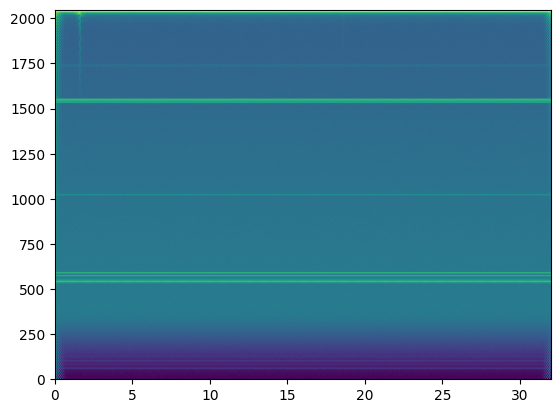

In [9]:
fig, ax = plt.subplots()
ax.imshow(np.log10(S.T), extent=[0., num_perseg/f_samp, 0., 0.5*f_samp], aspect='auto')
plt.show()

In [10]:
S[:,0] = 1.0

whitened = overlapping_data_TF[idx,:,:]/S

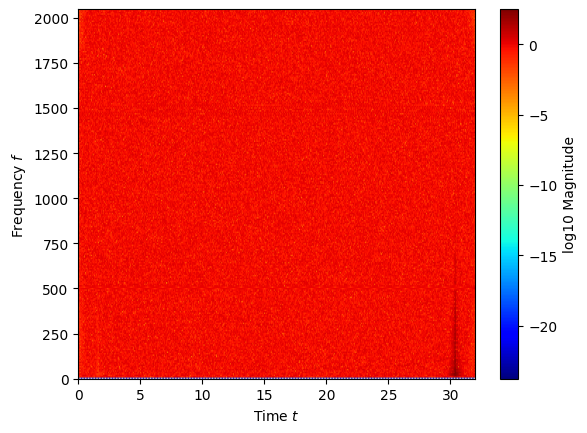

In [11]:
wdm.time_frequency_plot(whitened, scale='log')
plt.show()

In [13]:
import jax.numpy as jnp

whitened_TD = wdm.inverse_transform(jnp.array(whitened))

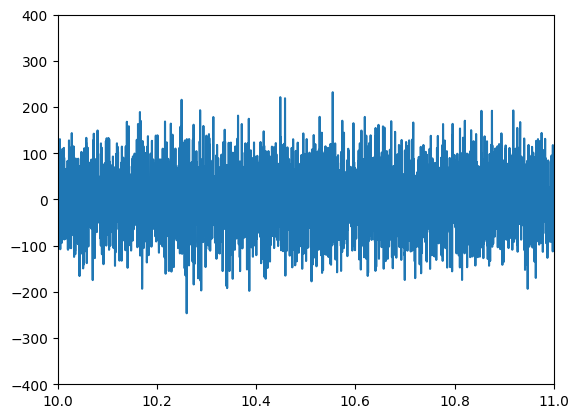

In [22]:
plt.plot(wdm.times, whitened_TD)
plt.xlim(10, 11)
plt.ylim(-400, 400)
plt.show()

In [ ]:
gps_time[]